### Financial Time Series Analysis

---

**Data:**
Stock Market Index values between 1994 and 2018
https://www.kaggle.com/regaipkurt/financial-markets?select=Index2018.csv

Dataset contains closing values for Financial Times Stock Exchange(FTSE), NIKKEI(Japan), S&P 500(USA), and DAX(German)


**Contents:**

<br>

* Fit the following models for time series analysis: 
* AR, MA, 
* ARMA, ARIMA, ARMAX, ARIMAX, 
* SARMA, SARIMAX
* ARCH

<br>


* Check for stationarity using rolling mean, rolling std plot and Dickey- Fuller test.
* Seasonal Decomposition to check for any seasonal trends in data.
* Using price returns instead of prices as stationary series for the analysis.
* ACF and PACF plots are used to select AR and MA models.
* Log-Likelihood Ratio test to select models.
* Residuals are plotted to see if they are white-noise errors.
* Practice predicting returns using some of the above models.
* Forecast Volatility using GARCH


---

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import statsmodels.api as sm

In [2]:
# load data - closing price of financial indices
# you could parse_dates and set_index within read_csv; but here I do it separately
data = pd.read_csv('Index2018.csv')

In [3]:
# make a copy of data to work on
df = data.copy()
df.head()

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


In [4]:
df.date = pd.to_datetime(df.date, dayfirst=True)

In [5]:
df.date.describe()

C:\Users\johnd\miniconda3\envs\tensor_env\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                    6269
unique                   6269
top       1994-01-07 00:00:00
freq                        1
first     1994-01-07 00:00:00
last      2018-01-29 00:00:00
Name: date, dtype: object

In [6]:
df.set_index('date', inplace=True)
df

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.900000,2224.95,3445.980000,18124.01
1994-01-10,475.270000,2225.00,3440.580000,18443.44
1994-01-11,474.130000,2228.10,3413.770000,18485.25
1994-01-12,474.170000,2182.06,3372.020000,18793.88
1994-01-13,472.470000,2142.37,3360.010000,18577.26
...,...,...,...,...
2018-01-23,2839.130362,13559.60,7731.827774,24124.15
2018-01-24,2837.544008,13414.74,7643.428966,23940.78
2018-01-25,2839.253031,13298.36,7615.839954,23669.49


In [7]:
# check for missing values 
df.isna().sum()

spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

In [8]:
# we specify a frequency 'business days' for our datetimeindex
df = df.asfreq('b')
df.isna().sum()


spx       8
dax       8
ftse      8
nikkei    8
dtype: int64

In [9]:
# we forwardfill missing values
df = df.fillna(method='ffill')

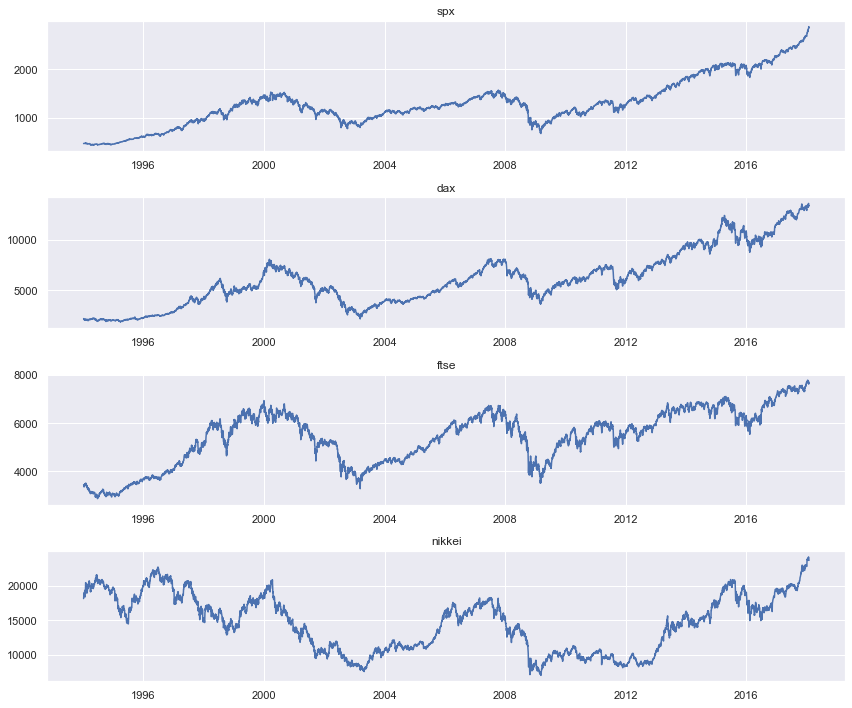

In [10]:
# plot each stock index
fig, ax = plt.subplots(4,1, figsize=(12,10))

for col, ax in zip(df.columns, ax.flatten()):
    ax.plot(df.index, df[col])
    ax.set_title(col)
    
plt.tight_layout()


In [11]:
# for time series analysis, here we only look at S&P 500
df = df.drop(['dax','ftse','nikkei'], axis=1)
df = df.rename(columns = {'spx':'market_value'})
df

,market_value
date,
1994-01-07,469.900000
1994-01-10,475.270000
1994-01-11,474.130000
1994-01-12,474.170000
1994-01-13,472.470000
...,...
2018-01-23,2839.130362
2018-01-24,2837.544008
2018-01-25,2839.253031


In [12]:
df.describe()

,market_value
count,6277.000000
mean,1288.642547
std,487.868210
min,438.920000
25%,992.715221
50%,1233.761241
75%,1460.250000
max,2872.867839


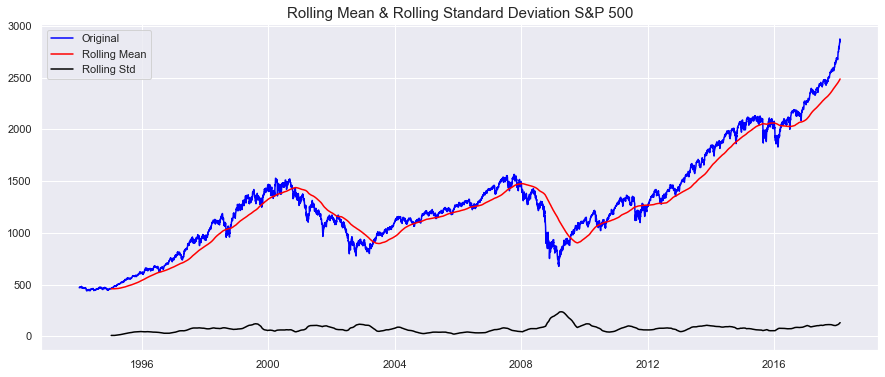

In [13]:
# here we check for stationarity using rolling mean an drolling std, window based on 264 working days per year
rolling_mean = df.rolling(window = 264).mean()       
rolling_std = df.rolling(window = 264).std()

plt.figure(figsize=(15,6))
plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation S&P 500', size=15)
plt.show()

# rolling mean increases with time, rolling std seems to increase over time. so not stationary.

In [14]:
# define train-test split, here 80:20 split
size = int(len(df)*0.80)
df_train = df.iloc[:size]
df_test = df.iloc[size:]

In [15]:
# no overlap of training and test set
df_train.tail()

,market_value
date,
2013-04-01,1562.173837
2013-04-02,1570.252238
2013-04-03,1553.686978
2013-04-04,1559.979316
2013-04-05,1553.278930


In [16]:
df_test.head()

,market_value
date,
2013-04-08,1563.071269
2013-04-09,1568.607909
2013-04-10,1587.731827
2013-04-11,1593.369863
2013-04-12,1588.854623


In [17]:
# Dickey-Fuller test for checking stationarity
import statsmodels.tsa.stattools as sts

sts.adfuller(df_train.market_value)
# ADF statistic
# p-value
# lags used in determining t-statistic
# no.of obs
# significance levels
# related to autocorrelation, lower this value easier it is to make predictions

(-1.736984745235244,
 0.41216456967706194,
 18,
 5002,
 {'1%': -3.431658008603046,
  '5%': -2.862117998412982,
  '10%': -2.567077669247375},
 39904.880607487445)

In [18]:
# we fail to reject the null, which means data is non-stationary.

In [19]:
# we can create white noise to check stationarity
wn = np.random.normal(loc = df_train.market_value.mean(), scale = df_train.market_value.std(), size=len(df_train))
df_train['wn'] = wn
df_train.describe()

C:\Users\johnd\miniconda3\envs\tensor_env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,market_value,wn
count,5021.000000,5021.000000
mean,1091.651926,1095.345342
std,292.559287,293.471950
min,438.920000,-47.447355
25%,914.620000,898.895990
50%,1144.650000,1096.249788
75%,1316.280729,1294.362665
max,1570.252238,2150.764562


In [20]:
# here we reject the null, which means white noise is stationary
sts.adfuller(df_train.wn)

(-51.1538182274404,
 0.0,
 1,
 5019,
 {'1%': -3.4316535759402753,
  '5%': -2.8621160400844468,
  '10%': -2.567076626752987},
 70833.86743173114)

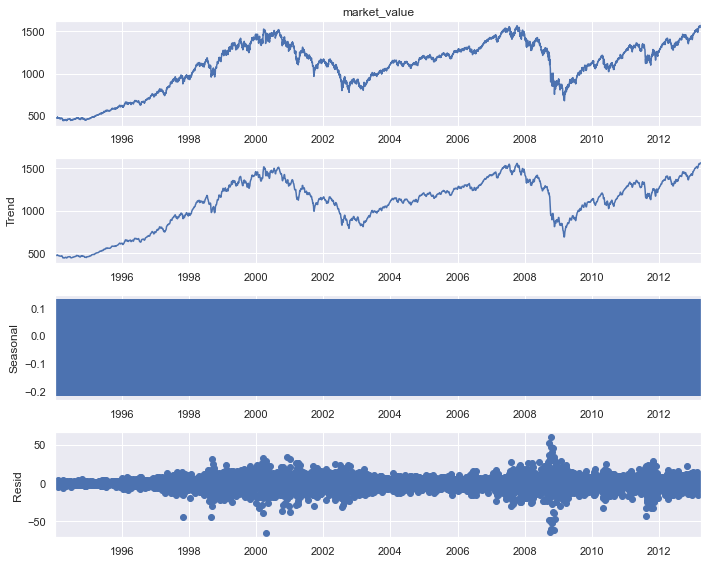

In [21]:
# next we do seasonal decomposition
# we do not find any seasonal patterns, trend closely resembles observed series
from statsmodels.tsa.seasonal import seasonal_decompose

s_dec_additive = seasonal_decompose(df_train.market_value, model = 'additive')

from pylab import rcParams
rcParams['figure.figsize'] = 10,8
s_dec_additive_plot = s_dec_additive.plot()

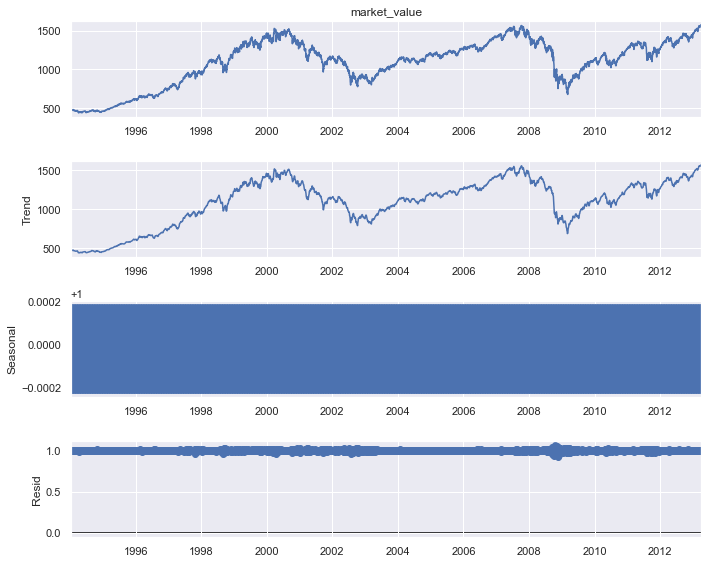

In [22]:
s_dec_multiplicative = seasonal_decompose(df_train.market_value, model = 'multiplicative')
from pylab import rcParams
rcParams['figure.figsize'] = 10,8
s_dec_multiplicative_plot = s_dec_multiplicative.plot()

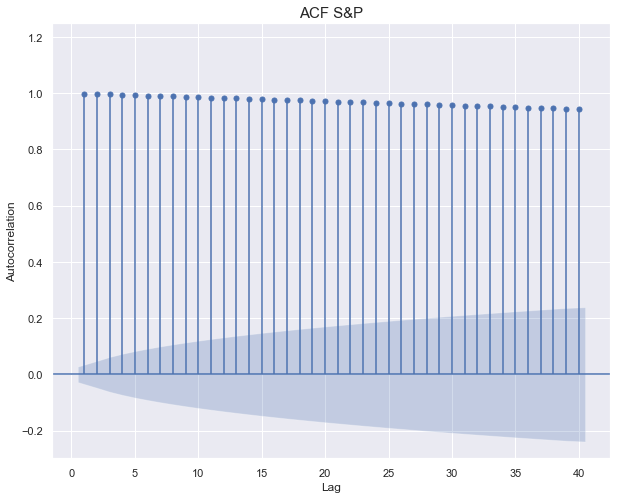

In [23]:
# plotting correlations
# ACF
import statsmodels.graphics.tsaplots as sgt

acf_plot = sgt.plot_acf(df_train.market_value, lags=40, zero=False, auto_ylims=True)
plt.title('ACF S&P', size=15)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation');

# values outside blue shaded region are significantly different from zero.
# we see significant autocorrelation that persists even after 30 lags 

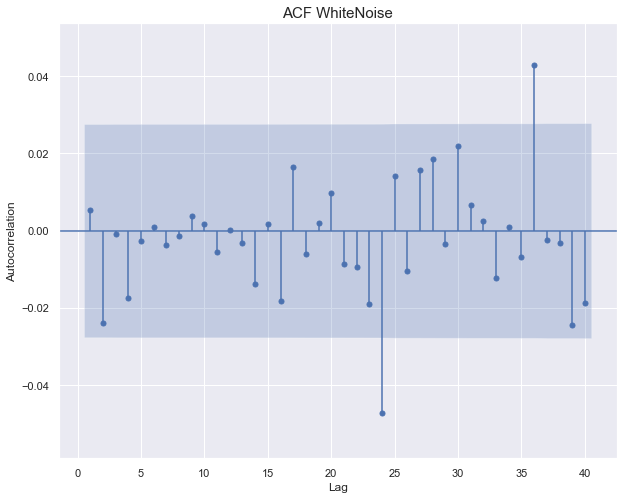

In [24]:
# ACF for white noise

acf_plot = sgt.plot_acf(df_train.wn, lags=40, zero=False, auto_ylims=True)
plt.title('ACF WhiteNoise', size=15)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation');

#we do not observe any significant autocorrelation between lags, 

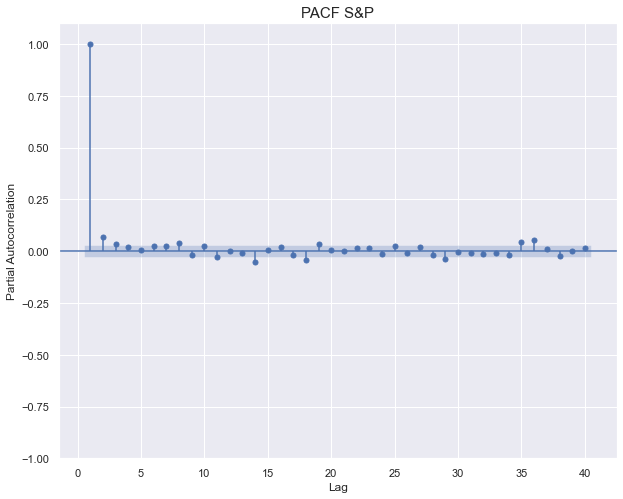

In [25]:
# PACF plot

pacf_plot = sgt.plot_pacf(df_train.market_value, lags=40, zero=False, method='ols')
plt.title('PACF S&P', size=15)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.ylim(-1,1.1);

# only 1st and 2nd lags seem significant, PACF shows the direct effect, eg: X_sub_t-2 --> X_sub_t
# But ACF takes into account all effects. eg: X_sub_t-2 --> X_sub_t-1 --> X_sub_t

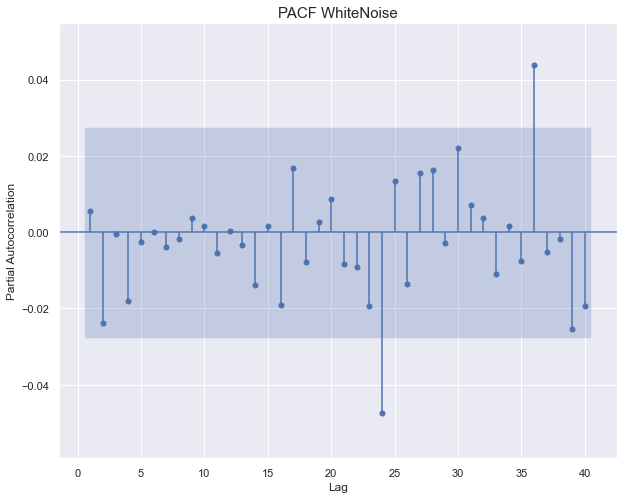

In [26]:
# PACF for White Noise
pacf_plot = sgt.plot_pacf(df_train.wn, lags=40, zero=False, method='ols', auto_ylims=True)
plt.title('PACF WhiteNoise', size=15)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation');

# no autocorrelation in whitenoise, those 2 values which look significant are just random.

In [27]:
from statsmodels.tsa.arima.model import ARIMA

In [28]:
# AR(1) model -> X_t = Constant + Beta1*X_t-1 + e_t

model_ar = ARIMA(df_train.market_value, order=(1,0,0))
results_ar = model_ar.fit()
results_ar.summary()
# we see that beta coefficient is close to 1 like in ACF and PACF graphs

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -20097.439
Date:                Thu, 10 Feb 2022   AIC                          40200.879
Time:                        12:10:55   BIC                          40220.443
Sample:                    01-07-1994   HQIC                         40207.734
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1091.6133    165.185      6.608      0.000     767.858    1415.369
ar.L1          0.9992      0.001   1695.377      0.000       0.998       1.000
sigma2       175.2480      1.771     98.978      0.000     171.778     178.718
===================================================================================
Ljung-Box (L1) (Q):                  24.60   Jarque-Bera (JB):              7473.06
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.29   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
# higher lag models
model_ar_2 = ARIMA(df_train.market_value, order=(2,0,0))
results_ar_2 = model_ar_2.fit()
results_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(2, 0, 0)   Log Likelihood              -20085.289
Date:                Thu, 10 Feb 2022   AIC                          40178.578
Time:                        12:10:59   BIC                          40204.664
Sample:                    01-07-1994   HQIC                         40187.719
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1091.6076    223.345      4.888      0.000     653.860    1529.355
ar.L1          0.9300      0.009     99.031      0.000       0.912       0.948
ar.L2          0.0694      0.009      7.405      0.000       0.051       0.088
sigma2       174.3966      1.768     98.654      0.000     170.932     177.861
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              7475.27
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               2.25   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
model_ar_3 = ARIMA(df_train.market_value, order=(3,0,0))
results_ar_3 = model_ar_3.fit()
results_ar_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(3, 0, 0)   Log Likelihood              -20083.003
Date:                Thu, 10 Feb 2022   AIC                          40176.005
Time:                        12:11:01   BIC                          40208.612
Sample:                    01-07-1994   HQIC                         40187.431
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1091.6519    119.496      9.135      0.000     857.444    1325.860
ar.L1          0.9271      0.009     97.886      0.000       0.909       0.946
ar.L2          0.0376      0.012      3.227      0.001       0.015       0.060
ar.L3          0.0342      0.008      4.437      0.000       0.019       0.049
sigma2       174.1643      1.799     96.828      0.000     170.639     177.690
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              7224.32
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               2.24   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
model_ar_4 = ARIMA(df_train.market_value, order=(4,0,0))
results_ar_4 = model_ar_4.fit()
results_ar_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(4, 0, 0)   Log Likelihood              -20081.936
Date:                Thu, 10 Feb 2022   AIC                          40175.873
Time:                        12:11:02   BIC                          40215.001
Sample:                    01-07-1994   HQIC                         40189.584
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1091.6519    121.400      8.992      0.000     853.712    1329.592
ar.L1          0.9264      0.009     97.776      0.000       0.908       0.945
ar.L2          0.0368      0.012      3.147      0.002       0.014       0.060
ar.L3          0.0148      0.012      1.272      0.203      -0.008       0.038
ar.L4          0.0208      0.009      2.249      0.025       0.003       0.039
sigma2       174.1229      1.800     96.734      0.000     170.595     177.651
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              7229.16
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               2.25   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
# here additional lags seem to give better fit, but this is due to non-stationarity
# we could check optimal model using log-likelihood test 

In [33]:
from scipy.stats.distributions import chi2
def LLR_test(mod_1, mod_2, DF=1):
    L1=mod_1.fit().llf
    L2=mod_2.fit().llf
    LR=(2*(L2-L1))
    p=chi2.sf(LR,DF).round(3)
    return p
    

In [34]:
# ar_3 offers better fit compared to ar_2, p value for log likelihood ratio test significant
LLR_test(model_ar_2, model_ar_3)

0.032

In [35]:
# we calculate returns using %change in prices
df_train['returns'] = df_train.market_value.pct_change().mul(100)
df_train = df_train.iloc[1:]

C:\Users\johnd\miniconda3\envs\tensor_env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [36]:
sts.adfuller(df_train.returns)
# here switching to returns turns data stationary

(-17.034457190981193,
 8.280537020316944e-30,
 17,
 5002,
 {'1%': -3.431658008603046,
  '5%': -2.862117998412982,
  '10%': -2.567077669247375},
 16035.926219345134)

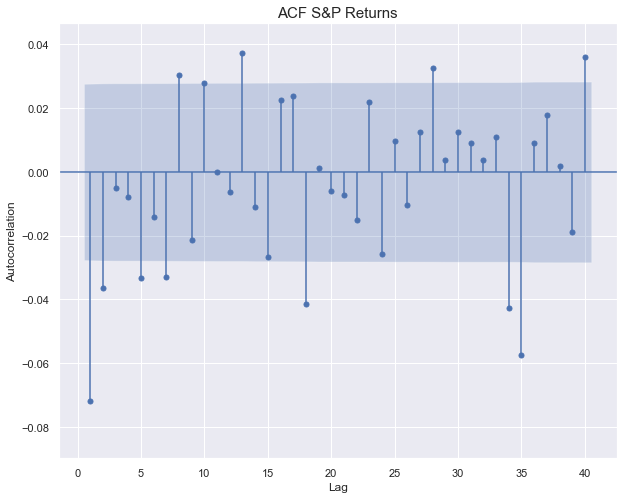

In [37]:
# plot ACF and PACF for returns

acf_plot = sgt.plot_acf(df_train.returns, lags=40, zero=False, auto_ylims=True)
plt.title('ACF S&P Returns', size=15)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation');

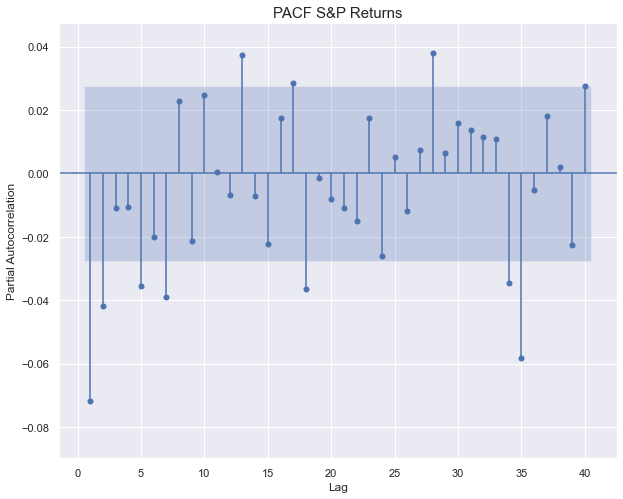

In [38]:
pacf_plot = sgt.plot_pacf(df_train.returns, lags=40, auto_ylims=True,zero=False, method='ols')
plt.title('PACF S&P Returns', size=15)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation');

In [39]:
# trying AR(2) model for returns based on above PACF

ret_ar_2 = ARIMA(df_train.returns, order=(2,0,0))
ret_results_ar_2 = ret_ar_2.fit()
ret_results_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -8063.177
Date:                Thu, 10 Feb 2022   AIC                          16134.354
Time:                        12:11:11   BIC                          16160.439
Sample:                    01-10-1994   HQIC                         16143.494
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0311      0.016      1.963      0.050    5.43e-05       0.062
ar.L1         -0.0749      0.009     -8.788      0.000      -0.092      -0.058
ar.L2         -0.0417      0.007     -6.035      0.000      -0.055      -0.028
sigma2         1.4543      0.013    108.088      0.000       1.428       1.481
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             13914.49
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               2.21   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [40]:
# to check if we need to consider higher lags, distant lags may not have such an impact on today's value.
# trying AR(7) model for returns based on above PACF

ret_ar_7 = ARIMA(df_train.returns, order=(7,0,0))
ret_results_ar_7 = ret_ar_7.fit()
ret_results_ar_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(7, 0, 0)   Log Likelihood               -8054.618
Date:                Thu, 10 Feb 2022   AIC                          16127.236
Time:                        12:11:15   BIC                          16185.926
Sample:                    01-10-1994   HQIC                         16147.802
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0311      0.015      2.136      0.033       0.003       0.060
ar.L1         -0.0773      0.009     -9.016      0.000      -0.094      -0.061
ar.L2         -0.0451      0.007     -6.518      0.000      -0.059      -0.032
ar.L3         -0.0140      0.009     -1.627      0.104      -0.031       0.003
ar.L4         -0.0147      0.008     -1.857      0.063      -0.030       0.001
ar.L5         -0.0386      0.007     -5.261      0.000      -0.053      -0.024
ar.L6         -0.0232      0.008     -3.051      0.002      -0.038      -0.008
ar.L7         -0.0389      0.007     -5.217      0.000      -0.054      -0.024
sigma2         1.4494      0.014    105.905      0.000       1.423       1.476
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             13333.85
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               2.21   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
# MA(1) model based on ACF

model_ret_ma_1 = ARIMA(df_train.returns[1:], order=(0,0,1))
results_ret_ma_1 = model_ret_ma_1.fit()
results_ret_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -8064.904
Date:                Thu, 10 Feb 2022   AIC                          16135.809
Time:                        12:11:16   BIC                          16155.372
Sample:                    01-11-1994   HQIC                         16142.664
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0309      0.016      1.911      0.056      -0.001       0.063
ma.L1         -0.0781      0.008     -9.241      0.000      -0.095      -0.062
sigma2         1.4562      0.013    112.931      0.000       1.431       1.482
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):             14761.16
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               2.22   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
# MA(7) model based on ACF

model_ret_ma_7 = ARIMA(df_train.returns[1:], order=(0,0,7))
results_ret_ma_7 = model_ret_ma_7.fit()
results_ret_ma_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(0, 0, 7)   Log Likelihood               -8054.143
Date:                Thu, 10 Feb 2022   AIC                          16126.286
Time:                        12:11:21   BIC                          16184.975
Sample:                    01-11-1994   HQIC                         16146.852
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0310      0.015      2.102      0.036       0.002       0.060
ma.L1         -0.0754      0.009     -8.771      0.000      -0.092      -0.059
ma.L2         -0.0394      0.007     -5.646      0.000      -0.053      -0.026
ma.L3         -0.0044      0.009     -0.510      0.610      -0.021       0.013
ma.L4         -0.0112      0.008     -1.407      0.159      -0.027       0.004
ma.L5         -0.0341      0.007     -4.572      0.000      -0.049      -0.019
ma.L6         -0.0119      0.008     -1.539      0.124      -0.027       0.003
ma.L7         -0.0302      0.007     -4.065      0.000      -0.045      -0.016
sigma2         1.4500      0.014    106.352      0.000       1.423       1.477
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             13454.88
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               2.22   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
# we can use LLR test to check if complex model fits better than simple model

**Residuals**

In [44]:
df_train['res_ret_ma_7'] = results_ret_ma_7.resid[1:]

In [45]:
print('Mean of Residuals: ' + str(round(df_train.res_ret_ma_7.mean(),3)))
print('Variance of Residuals: ' + str(round(df_train.res_ret_ma_7.var(),3)))
print('Standard deviation: ' + str(round(np.sqrt(df_train.res_ret_ma_7.var()),3)))

Mean of Residuals: 0.0
Variance of Residuals: 1.451
Standard deviation: 1.204


Text(0.5, 1.0, 'Residuals of Returns')

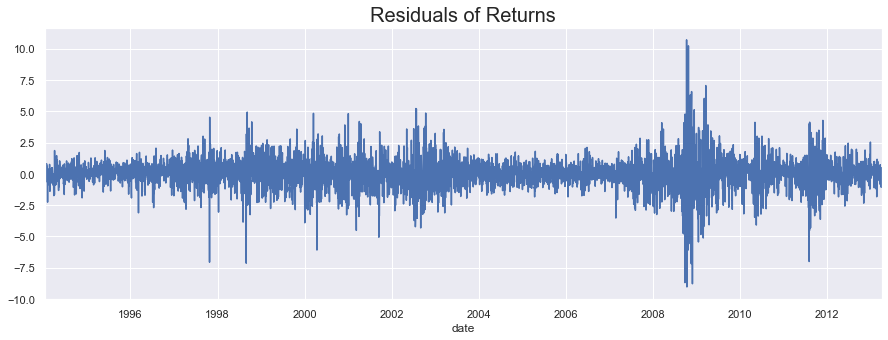

In [46]:
# plot the residuals

df_train['res_ret_ma_7'][1:].plot(figsize=(15,5))
plt.title('Residuals of Returns', size =20)

#seems somewhat stationary except for periods after late90's (dot-com) and 2008 crises.

In [47]:
# Dickey-Fuller test

sts.adfuller(df_train.res_ret_ma_7[2:])

# we see that residuals follow stationary series

(-70.88171092200223,
 0.0,
 0,
 5017,
 {'1%': -3.431654095870046,
  '5%': -2.8621162697870046,
  '10%': -2.5670767490325597},
 16028.506492908937)

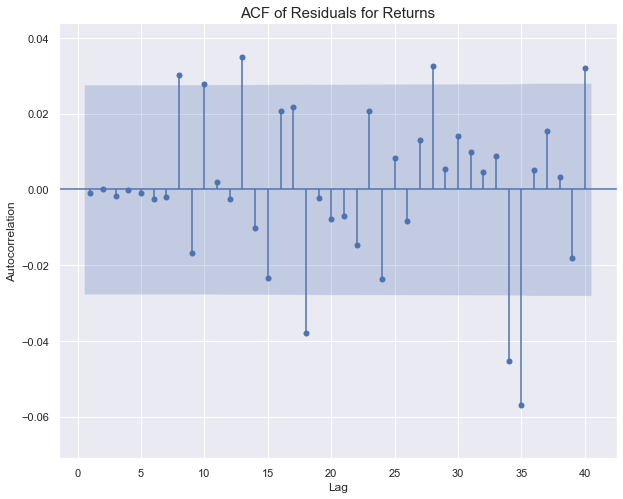

In [48]:
# we check ACF to see if residuals are white-noise

acf_plot = sgt.plot_acf(df_train.res_ret_ma_7[2:], lags=40, zero=False, auto_ylims=True)
plt.title('ACF of Residuals for Returns', size=15)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation');

# we see that most are insignificant, especially in the beginning

### ARMA(1,1)

In [49]:
model_ret_ar1_ma1 = ARIMA(df_train.returns[1:], order=(1,0,1))
results_ret_ar1_ma1 = model_ret_ar1_ma1.fit()
results_ret_ar1_ma1.summary()

# Interpretation: AR(1)positive relationship between past and present values, MA(1) negative relationship 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -8059.092
Date:                Thu, 10 Feb 2022   AIC                          16126.184
Time:                        12:11:26   BIC                          16152.267
Sample:                    01-11-1994   HQIC                         16135.324
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0310      0.015      2.039      0.041       0.001       0.061
ar.L1          0.6110      0.053     11.462      0.000       0.507       0.716
ma.L1         -0.6817      0.048    -14.156      0.000      -0.776      -0.587
sigma2         1.4529      0.013    108.654      0.000       1.427       1.479
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):             13591.22
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               2.22   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [50]:
# higher order models ARMA(2,1) 

model_ret_ar2_ma1 = ARIMA(df_train.returns[1:], order=(2,0,1))
results_ret_ar2_ma1 = model_ret_ar2_ma1.fit()
results_ret_ar2_ma1.summary()

# seems simpler model fits better

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -8058.647
Date:                Thu, 10 Feb 2022   AIC                          16127.294
Time:                        12:11:31   BIC                          16159.899
Sample:                    01-11-1994   HQIC                         16138.720
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0310      0.015      2.025      0.043       0.001       0.061
ar.L1          0.6752      0.062     10.823      0.000       0.553       0.797
ar.L2          0.0181      0.011      1.668      0.095      -0.003       0.039
ma.L1         -0.7518      0.061    -12.382      0.000      -0.871      -0.633
sigma2         1.4526      0.013    107.846      0.000       1.426       1.479
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             13776.63
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.22   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ARIMA(1,1,1)

In [51]:
model_arima_1 = ARIMA(df_train.market_value, order=(1,1,1))
results_model_arima_1 = model_arima_1.fit()
results_model_arima_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5020
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -20068.752
Date:                Thu, 10 Feb 2022   AIC                          40143.505
Time:                        12:11:32   BIC                          40163.068
Sample:                    01-10-1994   HQIC                         40150.360
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6011      0.063      9.532      0.000       0.478       0.725
ma.L1         -0.6694      0.057    -11.722      0.000      -0.781      -0.557
sigma2       174.0299      1.765     98.614      0.000     170.571     177.489
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):              7328.28
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               2.27   Skew:                            -0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

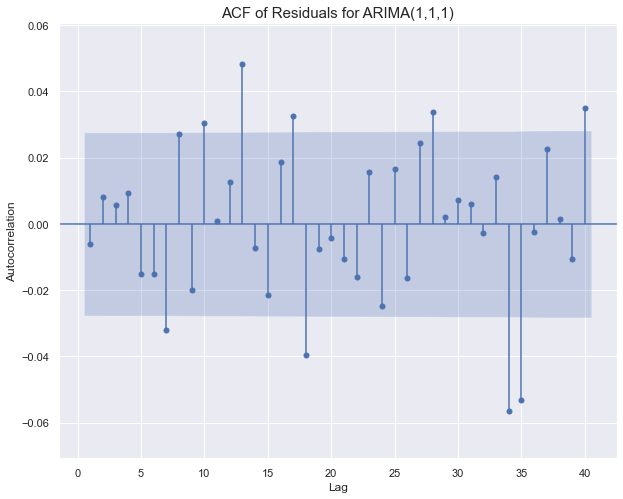

In [52]:
df_train['res_results_model_arima_1'] = results_model_arima_1.resid

sgt.plot_acf(df_train.res_results_model_arima_1[1:], lags=40, zero=False, auto_ylims=True)
plt.title('ACF of Residuals for ARIMA(1,1,1)', size=15)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation');

# we could check fit of higher order models up until 7 lags, ARIMA(7,1,7) and use LLR_test to find best fit
# then plot ACF of residuals and check if values are significant or not. if model fits-> ACF values wont be significant 

In [53]:
# creating a copy of original df
df_new = data.copy()
df_new.date = pd.to_datetime(df_new.date, dayfirst=True)
df_new.set_index('date', inplace=True)
df_new = df_new.asfreq('b')
df_new = df_new.fillna(method='ffill')

In [54]:
# returns
for i in df_new.columns:
    df_new['ret_{}'.format(i)] = df_new[i].pct_change(1)*100
    
#squared returns ftse
df_new['sq_ret_ftse'] = df_new['ret_ftse']**2

In [55]:
df_new

,spx,dax,ftse,nikkei,ret_spx,ret_dax,ret_ftse,ret_nikkei,sq_ret_ftse
date,,,,,,,,,
1994-01-07,469.900000,2224.95,3445.980000,18124.01,NaN,NaN,NaN,NaN,NaN
1994-01-10,475.270000,2225.00,3440.580000,18443.44,1.142796,0.002247,-0.156704,1.762469,0.024556
1994-01-11,474.130000,2228.10,3413.770000,18485.25,-0.239864,0.139326,-0.779229,0.226693,0.607198
1994-01-12,474.170000,2182.06,3372.020000,18793.88,0.008437,-2.066335,-1.222988,1.669601,1.495700
1994-01-13,472.470000,2142.37,3360.010000,18577.26,-0.358521,-1.818923,-0.356166,-1.152609,0.126854
...,...,...,...,...,...,...,...,...,...
2018-01-23,2839.130362,13559.60,7731.827774,24124.15,0.217307,0.712360,0.212382,1.292475,0.045106
2018-01-24,2837.544008,13414.74,7643.428966,23940.78,-0.055875,-1.068321,-1.143311,-0.760110,1.307159
2018-01-25,2839.253031,13298.36,7615.839954,23669.49,0.060229,-0.867553,-0.360951,-1.133171,0.130285


### Check Stationarity using pct_change of prices

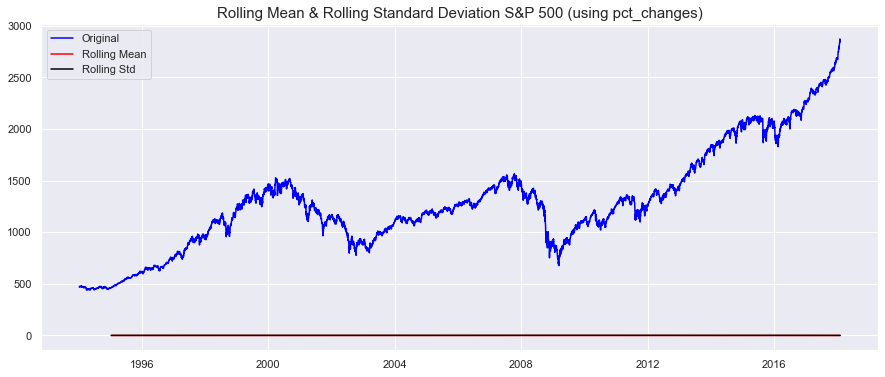

In [76]:
# here we check for stationarity using rolling mean an drolling std, window based on 264 working days per year
rolling_mean = df_new['ret_spx'].rolling(window = 264).mean()       
rolling_std = df_new['ret_spx'].rolling(window = 264).std()

plt.figure(figsize=(15,6))
plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation S&P 500 (using pct_changes)', size=15)
plt.show()

# we see that mean and std are constant.

In [56]:
size = int(len(df)*0.80)
df_new_train = df_new.iloc[:size]
df_new_test = df_new.iloc[size:]

## ARIMAX

In [57]:
model_arimax = ARIMA(df_new_train.ftse, exog=df_new_train.spx, order=(1,1,1)) 
results_arimax = model_arimax.fit()
results_arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   ftse   No. Observations:                 5021
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -26693.392
Date:                Thu, 10 Feb 2022   AIC                          53394.784
Time:                        12:11:38   BIC                          53420.869
Sample:                    01-07-1994   HQIC                         53403.925
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
spx            2.6928      0.035     76.407      0.000       2.624       2.762
ar.L1          0.2571      0.029      8.812      0.000       0.200       0.314
ma.L1         -0.5460      0.025    -21.791      0.000      -0.595      -0.497
sigma2      2433.0771     27.350     88.961      0.000    2379.472    2486.682
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):              4423.90
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                            -0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### SARIMAX

In [58]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [59]:
# we try to model SARIMAX(1,0,1)(2,0,1,5) X= spx prices

model_sarimax = SARIMAX(df_new_train.ftse, exog=df_new_train.spx, order=(1,0,1), seasonal_order=(2,0,1,5)) 
results_sarimax = model_sarimax.fit()
results_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                              ftse   No. Observations:                 5021
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 5)   Log Likelihood              -26712.680
Date:                           Thu, 10 Feb 2022   AIC                          53439.360
Time:                                   12:12:13   BIC                          53485.010
Sample:                               01-07-1994   HQIC                         53455.356
                                    - 04-05-2013                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
spx            2.7038      0.036     76.154      0.000       2.634       2.773
ar.L1          0.9998      0.000   2128.445      0.000       0.999       1.001
ma.L1         -0.3102      0.009    -33.233      0.000      -0.328      -0.292
ar.S.L5        0.9651      0.011     87.653      0.000       0.944       0.987
ar.S.L10       0.0345      0.010      3.333      0.001       0.014       0.055
ma.S.L5       -0.9987      0.006   -176.808      0.000      -1.010      -0.988
sigma2      2441.6198     28.439     85.855      0.000    2385.881    2497.359
===================================================================================
Ljung-Box (L1) (Q):                   1.63   Jarque-Bera (JB):              4209.11
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                            -0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 1.0, 'Returns')

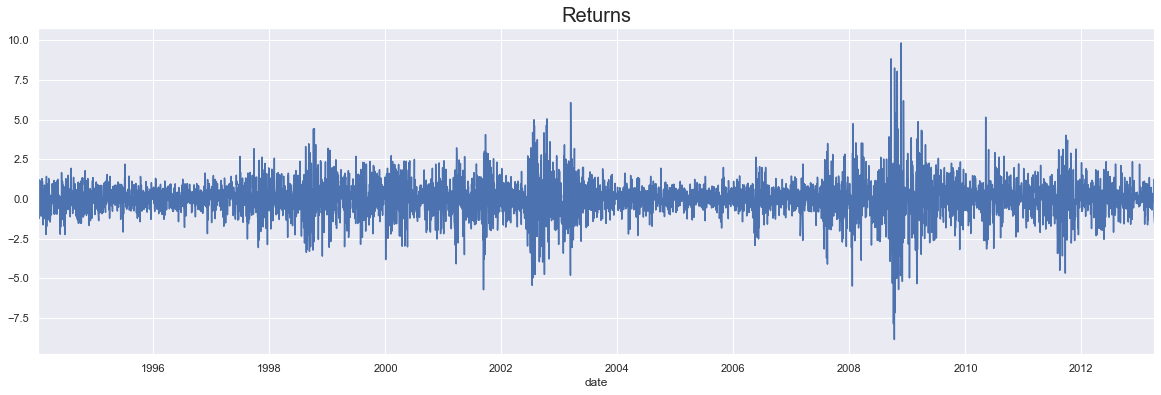

In [60]:
# returns and squared returns ftse index
df_new_train['ret_ftse'].plot(figsize=(20,6))
plt.title('Returns', size=20)

Text(0.5, 1.0, 'Volatility')

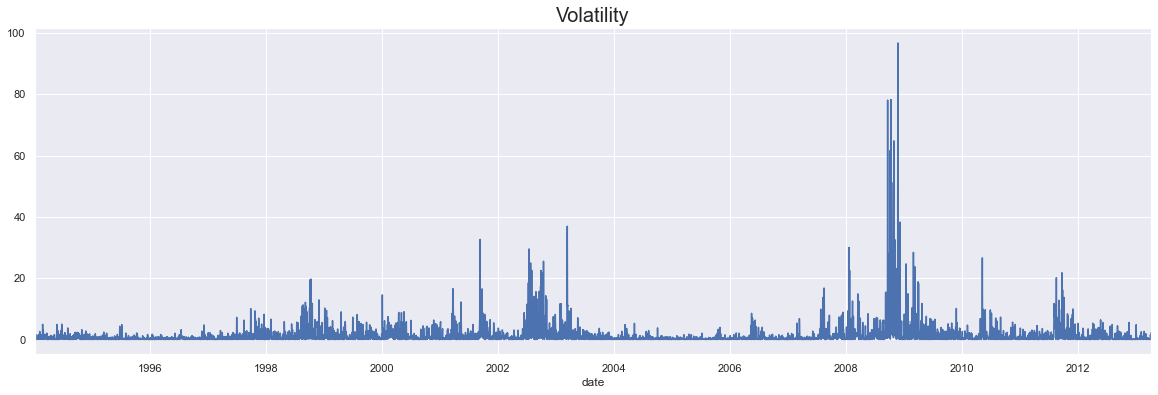

In [61]:
df_new_train['sq_ret_ftse'].plot(figsize=(20,6))
plt.title('Volatility', size=20)

## ARCH Model

In [62]:
from arch import arch_model

### ARCH(1)

In [63]:
model_arch_1= arch_model(df_new_train.ret_ftse[1:], mean='Constant', vol='ARCH', p=1)
results_arch_1 = model_arch_1.fit(update_freq=5)
results_arch_1.summary()

#contant mean so residuals are just a version of original data, no variation to explain r2=0

Iteration:      5,   Func. Count:     30,   Neg. LLF: 7660.08878204096
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7660.08878204096
            Iterations: 6
            Function evaluations: 33
            Gradient evaluations: 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:               ret_ftse   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7660.09
Distribution:                  Normal   AIC:                           15326.2
Method:            Maximum Likelihood   BIC:                           15345.7
                                        No. Observations:                 5020
Date:                Thu, Feb 10 2022   Df Residuals:                     5019
Time:                        12:12:15   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0345  1.603e-02      2.151  3.147e-02 [3.063e-03,6.590e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.9206  4.309e-02     21.365 2.855e-101 [  0.836,  1.005]
alpha[1]       0.3684  5.040e-02      7.310  2.673e-13 [  0.270,  0.467]
========================================================================

Covariance estimator: robust
"""

## Predictions, Forecasting

### AR

In [64]:
# fit AR_1 model

model_ar = ARIMA(df_new_train.ftse, order=(1,0,0))
results_ar = model_ar.fit()
#results_ar.summary()

In [65]:
df_new_train.tail()

,spx,dax,ftse,nikkei,ret_spx,ret_dax,ret_ftse,ret_nikkei,sq_ret_ftse
date,,,,,,,,,
2013-04-01,1562.173837,7795.31,6411.74,12135.02,-0.446858,0.000000,0.000000,-2.120438,0.000000
2013-04-02,1570.252238,7943.87,6490.66,12003.43,0.517126,1.905761,1.230867,-1.084382,1.515034
2013-04-03,1553.686978,7874.75,6420.28,12362.20,-1.054943,-0.870105,-1.084327,2.988896,1.175766
2013-04-04,1559.979316,7817.39,6344.11,12634.54,0.404994,-0.728404,-1.186397,2.203006,1.407537
2013-04-05,1553.278930,7658.75,6249.77,12833.64,-0.429518,-2.029322,-1.487049,1.575839,2.211314


In [66]:
start_date = '2013-04-06'
end_date = '2014-01-01'

Text(0.5, 1.0, 'Predictions vs. Actual')

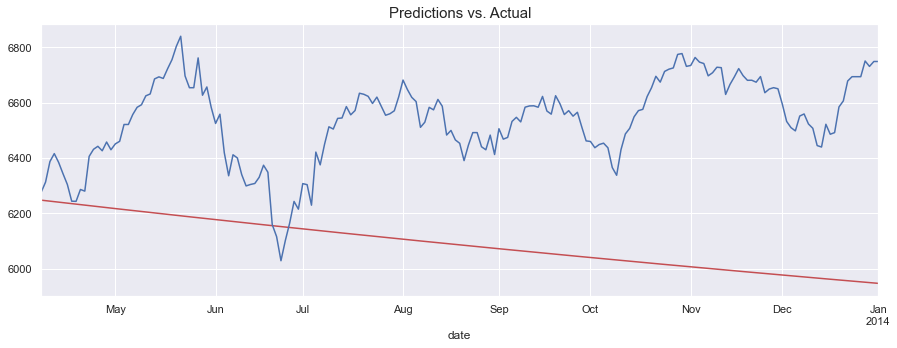

In [67]:
df_pred = results_ar.predict(start=start_date, end=end_date)
plt.figure(figsize=(15,5))
df_pred[start_date:end_date].plot(c='r')
df_new_test[start_date:end_date].ftse.plot(c="b")
plt.title('Predictions vs. Actual', size=15)
# our AR model does not predict non-stationary data well, redline continues downwards while ftse index does not

Text(0.5, 1.0, 'Predictions vs. Actual (Returns)')

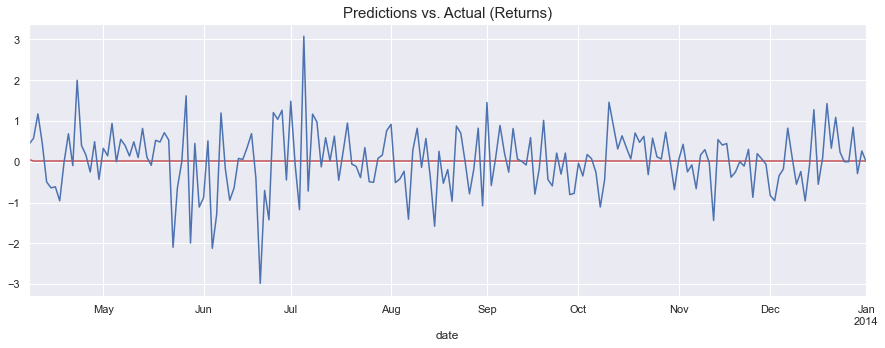

In [68]:
# lets try price returns instead

model_ar_ret = ARIMA(df_new_train.ret_ftse[1:], order=(1,0,0))
results_ar_ret = model_ar_ret.fit()

df_pred_ret = results_ar_ret.predict(start=start_date, end=end_date)
plt.figure(figsize=(15,5))
df_pred_ret[start_date:end_date].plot(c='r')
df_new_test.ret_ftse[start_date:end_date].plot(c="b")
plt.title('Predictions vs. Actual (Returns)', size=15)

# model does not work well

### ARMAX

Text(0.5, 1.0, 'Predictions vs. Actual (Returns)')

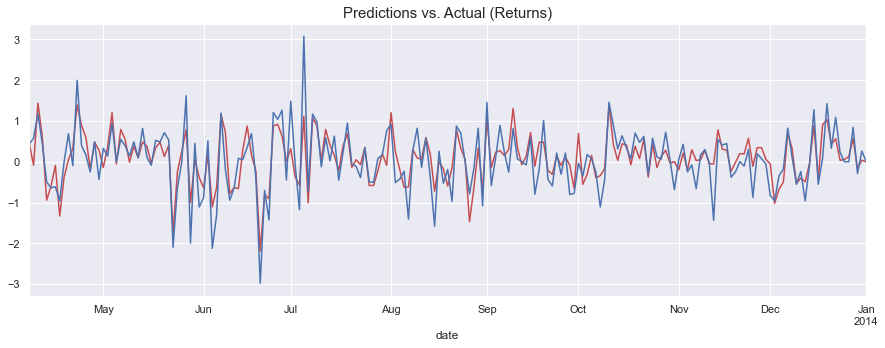

In [69]:
model_arimax = ARIMA(df_new_train.ret_ftse[1:], exog=df_new_train[['ret_spx','ret_dax','ret_nikkei']][1:],order=(1,0,1))
results_arimax = model_arimax.fit()

df_pred_ret = results_arimax.predict(start=start_date, end=end_date, 
                                     exog=df_new_test[['ret_spx','ret_dax','ret_nikkei']][start_date:end_date])
plt.figure(figsize=(15,5))
df_pred_ret[start_date:end_date].plot(c='r')
df_new_test.ret_ftse[start_date:end_date].plot(c="b")
plt.title('Predictions vs. Actual (Returns)', size=15)

### SARMA

C:\Users\johnd\miniconda3\envs\tensor_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Text(0.5, 1.0, 'Predictions vs. Actual (Returns)')

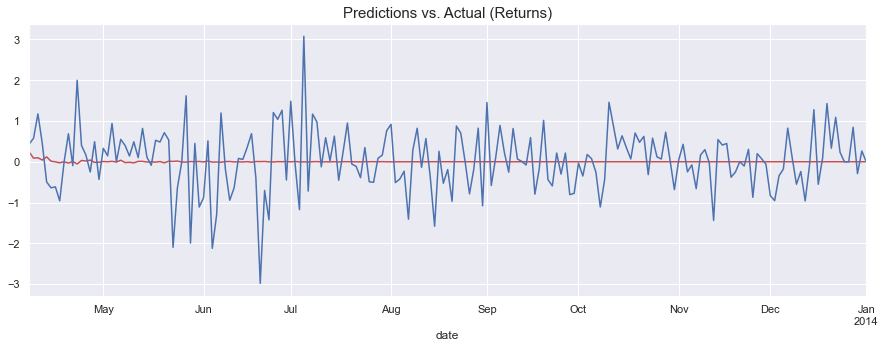

In [70]:
model_sarma = SARIMAX(df_new_train.ret_ftse[1:],order=(3,0,4), seasonal_order=(3,0,2,5))      #s=5 since 5 workdays/week
results_sarma = model_sarma.fit()

df_pred_sarma = results_sarma.predict(start=start_date, end=end_date)

plt.figure(figsize=(15,5))
df_pred_sarma[start_date:end_date].plot(c='r')
df_new_test.ret_ftse[start_date:end_date].plot(c="b")
plt.title('Predictions vs. Actual (Returns)', size=15)

### SARIMAX

C:\Users\johnd\miniconda3\envs\tensor_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Text(0.5, 1.0, 'Predictions vs. Actual (Returns)')

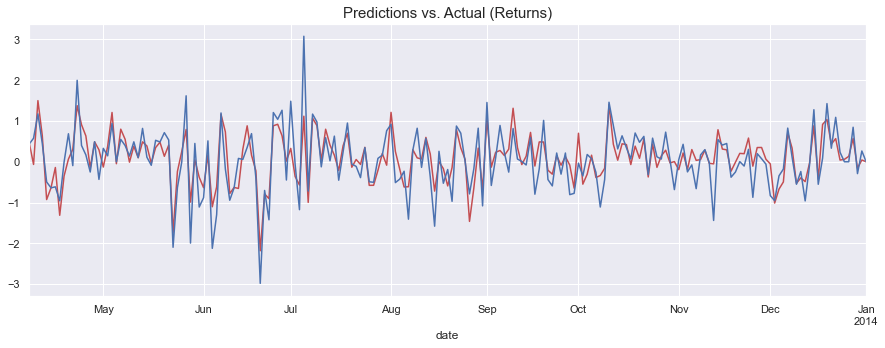

In [71]:
model_sarimax = SARIMAX(df_new_train.ret_ftse[1:],order=(3,0,4), seasonal_order=(3,0,2,5), 
                      exog=df_new_train[['ret_spx','ret_dax','ret_nikkei']][1:])      #s=5 since 5 workdays/week
results_sarimax = model_sarimax.fit()

df_pred_sarimax = results_sarimax.predict(start=start_date, end=end_date, 
                                          exog=df_new_test[['ret_spx','ret_dax','ret_nikkei']][start_date:end_date])

plt.figure(figsize=(15,5))
df_pred_sarimax[start_date:end_date].plot(c='r')
df_new_test.ret_ftse[start_date:end_date].plot(c="b")
plt.title('Predictions vs. Actual (Returns)', size=15)

### Forecast Volatility

In [72]:
model_garch = arch_model(df_new.ret_ftse[1:], vol='GARCH', p=1, q=1, mean='Constant', dist='Normal')
res_garch = model_garch.fit(last_obs=start_date, update_freq=10)
#got error with training data, cant plot, hence df_new, need to look into this more

Iteration:     10,   Func. Count:     64,   Neg. LLF: 6970.058478416067
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6970.058366189876
            Iterations: 13
            Function evaluations: 78
            Gradient evaluations: 13


In [73]:
pred_garch= res_garch.forecast(horizon=1, align='target', reindex=True)

Text(0.5, 1.0, 'Volatility Predictions')

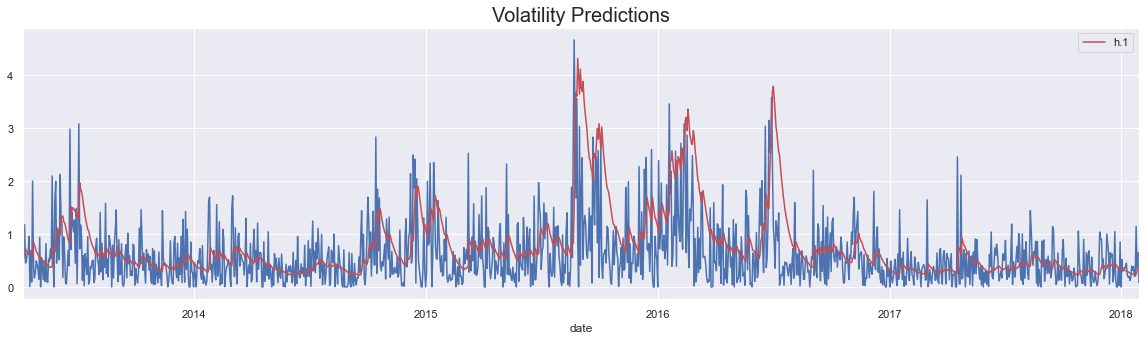

In [74]:
pred_garch.residual_variance[start_date:].plot(figsize=(20,5), c='r', zorder=2)
df_new_test.ret_ftse[start_date:].abs().plot(c='b', zorder=1)
plt.title('Volatility Predictions', size=20)